# SVM Linear Classifiers with Text

In this notebook we will apply a Linear SVM to our text classification
problem.

As the bag of words representation of a document is high dimensional we will use $\chi^2$ feature selection to select a subspace of a manageable dimension. 


## Preliminaries

### Imports

In [1]:
import pickle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer

from sklearn import metrics
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.model_selection import train_test_split,KFold
from sklearn.preprocessing import LabelEncoder, OneHotEncoder


# for a progress bar on slow calculations
from ipywidgets import IntProgress
from IPython.display import display

import sys
sys.path.append("../..")
from E4525_ML import plots
import E4525_ML.text as text
from E4525_ML.multiclass_svm import SVMGDClassifier
%matplotlib inline
plt.rcParams['figure.figsize'] = (8.0, 6.0) # set default size of plots

In [2]:
seed=23
np.random.seed(seed)

### Data

#### Data Directories

In [3]:
raw_data_dir=r"../../raw/C50/C50train"
test_dir    =r"../../raw/C50/C50test"
data_dir=r"../../data/C50"


#### Corpus

In [4]:
documents_filename=data_dir+"/C50_documents.csv"
documents=pd.read_csv(documents_filename,index_col="document_id")
documents.head()

,filename,label
document_id,,
0,../../raw/C50/C50train/AaronPressman/106247new...,AaronPressman
1,../../raw/C50/C50train/AaronPressman/120600new...,AaronPressman
2,../../raw/C50/C50train/AaronPressman/120683new...,AaronPressman
3,../../raw/C50/C50train/AaronPressman/136958new...,AaronPressman
4,../../raw/C50/C50train/AaronPressman/137498new...,AaronPressman


In [5]:
test_documents_filename=data_dir+"/C50_test_documents.csv"
test_documents=pd.read_csv(test_documents_filename,index_col="document_id")
test_documents.head()

,filename,label
document_id,,
0,../../raw/C50/C50test/AaronPressman/421829news...,AaronPressman
1,../../raw/C50/C50test/AaronPressman/424074news...,AaronPressman
2,../../raw/C50/C50test/AaronPressman/42764newsM...,AaronPressman
3,../../raw/C50/C50test/AaronPressman/43033newsM...,AaronPressman
4,../../raw/C50/C50test/AaronPressman/433558news...,AaronPressman


In [6]:
scramble=True

In [7]:
if scramble:
    all_docs=pd.concat([documents,test_documents])
    print("all_docs.shape",all_docs.shape)
    msk=np.random.rand(len(all_docs))<0.5
    documents=all_docs[msk]
    test_documents=all_docs[~msk]
    print(documents.shape,test_documents.shape)

all_docs.shape (5000, 2)
(2584, 2) (2416, 2)



## Validation Set Creation

In [8]:
docs_train,docs_val,Y_train,Y_val=train_test_split(documents["filename"],documents["label"],test_size=0.2)

We use `set` features as those perform better for all the other classifiers.

We normalize vectors so that $x^T x =1$ for each document by using the `TFidfVectorizer` class with normalization set.

In [9]:
countVectorizer=TfidfVectorizer(input="filename",
                                      
                                       norm="l2",
                                       tokenizer=text.stem_tokenizer,
                                       stop_words=text.stop_words())

## Select More important Features

In [10]:
F=1000

In [11]:
X=countVectorizer.fit_transform(docs_train)
Y=Y_train

In [12]:
V=X.shape[1]
V

27684

In [13]:
dummies=pd.get_dummies(Y,prefix="",prefix_sep="",sparse=True)
labels=dummies.columns
Z=dummies

In [14]:
transformer=SelectKBest(chi2,F) # get the best F based on chi2 metric

In [15]:
Xt=transformer.fit_transform(X,Z) # Return X with only the selected features

In [16]:
feature_idx=transformer.get_support(True)

In [17]:
index_2_word=countVectorizer.get_feature_names()

In [18]:
for idx in feature_idx[-10:]:
    print(idx,index_2_word[idx])

27527 yorkshir
27533 yoshinobu
27545 yuan
27558 yukon
27563 yuri
27565 yushiro
27597 zealand
27599 zedong
27605 zemin
27657 zivnostenska


## Generic Text Classifier with Feature Selection

Selection $F$ features base of a $\chi^2$ test makes sense for any classifier.

For convenience we create a new wrapper classifier that selects $F$ features and calls the underlying
classier with them.

In [19]:
class TextChi2Classifier:
    def __init__(self,F,model):
        self.model=model
        self.transformer=SelectKBest(chi2,F)
    def fit(self,X,Y,X_val,Y_val):
        dummies=pd.get_dummies(Y,prefix="",prefix_sep="",sparse=True)
        Z=dummies
        Xt=self.transformer.fit_transform(X,Z)
        Xt_val=self.transformer.transform(X_val)
        self.model.fit(Xt,Y,Xt_val,Y_val)
        return self
    def predict(self,X):
        Xt=self.transformer.transform(X)
        return self.model.predict(Xt)

 ##  SVM Classifier vs Number of Features

In [20]:
X=countVectorizer.fit_transform(docs_train)
Y=Y_train
X.shape,Y.shape

((2067, 27684), (2067,))

In [21]:
X_val=countVectorizer.transform(docs_val)
X_val.shape,Y_val.shape

((517, 27684), (517,))

In [22]:
Fs=[100,200,300,500,1000,2000,3000,5000,10000,20000,V]

In [23]:
base_model=SVMGDClassifier(max_iter=100, learning_rate=0.005,tol=1e-8)

In [24]:
# Display a progress bar that counts how many training rounds we have done so far
progress2= IntProgress(min=0, max=len(Fs),description="Trials:",bar_style="info")
display(progress2)


logistic_train_error=[]
logistic_val_error=[]
progress2.value=0
for F in Fs:
    print("F",F)
    model=TextChi2Classifier(F,base_model)
    model.fit(X,Y,X_val,Y_val)
    Y_pred=model.predict(X)
    logistic_train_error.append(1-np.mean(Y_pred==Y))
    Y_pred=model.predict(X_val)
    logistic_val_error.append(1-np.mean(Y_pred==Y_val))
    progress2.value+=1
print("Done.")

F 100
	 0 Loss = 101490.896927 Train_Accuracy 0.0183841315917 Evaluation Loss = 25402.689135 Accuracy = 0.0174081237911
	 10 Loss = 38196.3281344 Train_Accuracy 0.208998548621 Evaluation Loss = 9982.64480388 Accuracy = 0.191489361702
	 20 Loss = 24469.1073656 Train_Accuracy 0.298500241896 Evaluation Loss = 6671.28411336 Accuracy = 0.220502901354
	 30 Loss = 18907.9356099 Train_Accuracy 0.419448476052 Evaluation Loss = 5008.33146917 Accuracy = 0.382978723404
	 40 Loss = 16894.2795153 Train_Accuracy 0.44992743106 Evaluation Loss = 4655.87882675 Accuracy = 0.410058027079
	 50 Loss = 15184.8198766 Train_Accuracy 0.445089501693 Evaluation Loss = 4306.90742018 Accuracy = 0.363636363636
	 60 Loss = 14791.4978949 Train_Accuracy 0.447992259313 Evaluation Loss = 4262.17368505 Accuracy = 0.371373307544
	 70 Loss = 13566.452021 Train_Accuracy 0.473149492017 Evaluation Loss = 3905.97850294 Accuracy = 0.394584139265
	 80 Loss = 12904.325315 Train_Accuracy 0.48137397194 Evaluation Loss = 3772.4089674

	 60 Loss = 578.876514213 Train_Accuracy 0.977745524915 Evaluation Loss = 1902.43296867 Accuracy = 0.777562862669
	 70 Loss = 497.892166227 Train_Accuracy 0.981615868408 Evaluation Loss = 1856.33608215 Accuracy = 0.771760154739
	 80 Loss = 431.811416938 Train_Accuracy 0.983067247218 Evaluation Loss = 1844.18560325 Accuracy = 0.775628626692
	 90 Loss = 378.473174824 Train_Accuracy 0.985486211901 Evaluation Loss = 1819.95443311 Accuracy = 0.773694390716
	 99 Loss = 338.338911158 Train_Accuracy 0.987905176584 Evaluation Loss = 1814.40757475 Accuracy = 0.775628626692
F 5000
	 0 Loss = 101247.037569 Train_Accuracy 0.0261248185776 Evaluation Loss = 25311.0184809 Accuracy = 0.0328820116054
	 10 Loss = 1763.70027623 Train_Accuracy 0.969521044993 Evaluation Loss = 2894.81644211 Accuracy = 0.756286266925
	 20 Loss = 887.140664447 Train_Accuracy 0.976777939042 Evaluation Loss = 2528.79863835 Accuracy = 0.78916827853
	 30 Loss = 594.075709641 Train_Accuracy 0.985002418965 Evaluation Loss = 2357.65

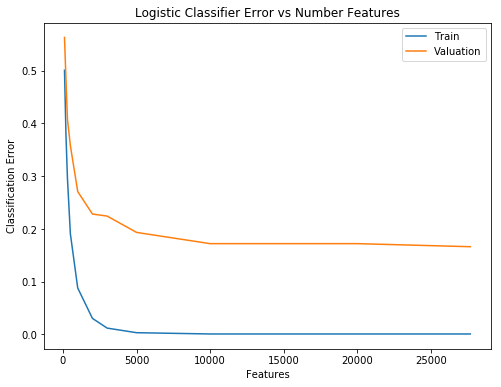

In [25]:
plt.plot(Fs,logistic_train_error,label="Train")
plt.plot(Fs,logistic_val_error,label="Valuation")
plt.legend()
plt.title("Logistic Classifier Error vs Number Features")
plt.xlabel("Features")
plt.ylabel("Classification Error")

In [26]:
best_idx=np.array(logistic_val_error).argmin()
best_F=Fs[best_idx]
print(best_F,logistic_val_error[best_idx])

27684 0.166344294004


1. The model is overfitting (training error is 0 after a few hundred Features)
2. Test Error stabilizes after roughtly 5k features
3. Logistic Regression performance does not degrade after we keep increasing the number of features

Best Accuracy is $\approx 83\%$, slightly worse than logistic regression.

## Regularization of the SVM Regression Classifier

In [27]:
penalties=[0.0001,0.001,0.01,0.1,1,10,100]

In [28]:
# Display a progress bar that counts how many training rounds we have done so far
#progress3= IntProgress(min=0, max=len(Cs),description="Trials:",bar_style="info")
#display(progress3)

train_error=[]
val_error=[]
#progress3.value=0
for penalty in penalties:
    print("penalty:",penalty)
    base_model=SVMGDClassifier(penalty=penalty,
                               max_iter=100, 
                               learning_rate=0.005,
                               tol=1e-8)
    model=TextChi2Classifier(best_F,base_model)
    model.fit(X,Y,X_val,Y_val)
    Y_pred=model.predict(X)
    train_error.append(1-np.mean(Y_pred==Y))
    Y_pred=model.predict(X_val)
    val_error.append(1-np.mean(Y_pred==Y_val))
    #progress3.value+=1
print("Done.")

penalty: 0.0001
	 0 Loss = 101271.929173 Train_Accuracy 0.025641025641 Evaluation Loss = 25320.2133817 Accuracy = 0.0135396518375
	 10 Loss = 727.5620976 Train_Accuracy 0.989356555394 Evaluation Loss = 3391.44943766 Accuracy = 0.796905222437
	 20 Loss = 342.055249678 Train_Accuracy 0.993710691824 Evaluation Loss = 3202.47242368 Accuracy = 0.806576402321
	 30 Loss = 202.936555619 Train_Accuracy 0.996613449444 Evaluation Loss = 3091.96932234 Accuracy = 0.822050290135
	 40 Loss = 128.09759065 Train_Accuracy 0.998064828254 Evaluation Loss = 3051.30681561 Accuracy = 0.829787234043
	 50 Loss = 87.7355399411 Train_Accuracy 0.99854862119 Evaluation Loss = 3033.17513039 Accuracy = 0.829787234043
	 60 Loss = 60.2985702455 Train_Accuracy 0.99854862119 Evaluation Loss = 3018.06090749 Accuracy = 0.827852998066
	 70 Loss = 43.0837035972 Train_Accuracy 0.999032414127 Evaluation Loss = 3007.75977396 Accuracy = 0.835589941973
	 80 Loss = 31.6909871679 Train_Accuracy 0.999032414127 Evaluation Loss = 300

	 60 Loss = 49033.5837445 Train_Accuracy 0.661344944364 Evaluation Loss = 36906.77334 Accuracy = 0.425531914894
	 70 Loss = 48750.6522176 Train_Accuracy 0.624092888244 Evaluation Loss = 37113.1120706 Accuracy = 0.323017408124
	 80 Loss = 48849.5543074 Train_Accuracy 0.688437348815 Evaluation Loss = 36897.99089 Accuracy = 0.441005802708
	 90 Loss = 50241.4546443 Train_Accuracy 0.494920174165 Evaluation Loss = 37083.0882985 Accuracy = 0.282398452611
	 99 Loss = 48721.6460653 Train_Accuracy 0.654571843251 Evaluation Loss = 36894.8828033 Accuracy = 0.37330754352
Done.


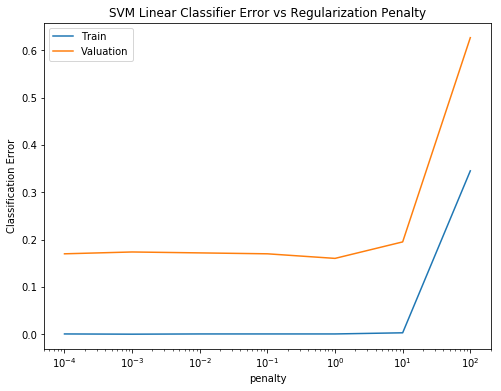

In [29]:
plt.plot(penalties,train_error,label="Train")
plt.plot(penalties,val_error,label="Valuation")
plt.legend()
plt.title("SVM Linear Classifier Error vs Regularization Penalty")
plt.xlabel(r"penalty")
plt.xscale("log")
plt.ylabel("Classification Error")

In [31]:
best_idx=np.array(val_error).argmin()
best_penalty=penalties[best_idx]
print(best_F,best_penalty,val_error[best_idx])

27684 1 0.160541586074


We have achieved a 84% accuracy comparable to Logistic Regression.

In [36]:
X=countVectorizer.fit_transform(documents["filename"])

In [38]:
X_test=countVectorizer.transform(test_documents["filename"])

In [39]:
Y=documents["label"]
Y_test=test_documents["label"]

In [40]:
base_model=SVMGDClassifier(penalty=best_penalty,
                               max_iter=100, 
                               learning_rate=0.005,
                               tol=1e-8)
model=TextChi2Classifier(best_F,base_model)
model.fit(X,Y,X_test,Y_test)

	 0 Loss = 126612.991702 Train_Accuracy 0.0185758513932 Evaluation Loss = 118387.881566 Accuracy = 0.012417218543
	 10 Loss = 1982.82866858 Train_Accuracy 0.988003095975 Evaluation Loss = 13721.044254 Accuracy = 0.815397350993
	 20 Loss = 1548.26547361 Train_Accuracy 0.993034055728 Evaluation Loss = 13713.2583151 Accuracy = 0.829470198675
	 30 Loss = 1370.66745277 Train_Accuracy 0.995743034056 Evaluation Loss = 14467.3384193 Accuracy = 0.835264900662
	 40 Loss = 1264.76799676 Train_Accuracy 0.99806501548 Evaluation Loss = 15185.3369118 Accuracy = 0.844784768212
	 50 Loss = 1194.04572031 Train_Accuracy 0.99806501548 Evaluation Loss = 16167.477063 Accuracy = 0.846026490066
	 60 Loss = 1142.47687175 Train_Accuracy 0.999226006192 Evaluation Loss = 17004.0471593 Accuracy = 0.848509933775
	 70 Loss = 1105.71894285 Train_Accuracy 0.999226006192 Evaluation Loss = 17876.96091 Accuracy = 0.851821192053
	 80 Loss = 1078.67122442 Train_Accuracy 0.999226006192 Evaluation Loss = 18827.142172 Accurac

In [41]:
Y_pred=model.predict(X_test)
np.mean(Y_pred==Y_test)

0.85802980132450335

We achieve nearly 86% accuracy, very slighly better than LogisticRegression (85.80% vs 85.76%)